## Stack - Projeto Human Resources Analytics

### Análise Exploratória de Dados.

In [1]:
# Estrutura de dados.
import pandas as pd

# Operações com objetos temporais.
import datetime

# Leitura de arquivos.
import glob

# Conexão com o datalake.
from minio import Minio

# Visualização gráfica.
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrando avisos.
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Instanciando o cliente do datalake.
client = Minio(
    "localhost:9000",  # IP do datalake.
    access_key="minioadmin",  # Usuário.
    secret_key="minioadmin",  # Senha.
    secure=False,  # Desabilitando conexão segura.
)

### Baixando o Dataset do Data Lake.

In [3]:
# Recuperando arquivo do datalake.
client.fget_object(
    "processing",  # Nome do bucket.
    "employees_dataset.parquet",  # Nome do arquivo.
    "temp_.parquet",  # Nome do arquivo temporário associado ao arquivo anterior
    # que será salvo localmente para leitura.
)

In [4]:
# Leitura do arquivo.
df = pd.read_parquet("temp_.parquet")

In [5]:
df.head()

,department,salary,left,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,0.0
1,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,0.0
2,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,0.0
3,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,0.0
4,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,0.0


#### Organizando o dataset.

In [6]:
df = df[
    [
        "department",
        "salary",
        "mean_work_last_3_months",
        "number_projects",
        "satisfaction_level",
        "last_evaluation",
        "time_in_company",
        "work_accident",
        "left",
    ]
]

In [7]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0


#### Verificando registros nulos.

In [8]:
df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [9]:
# Dropando o único valor faltante encontrado.
df.dropna(inplace=True)

In [10]:
df.isnull().sum().sum()

0

#### Alterando os tipos de dados.

In [11]:
# Convertendo atributos para inteiro.
df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   department               14999 non-null  object 
 1   salary                   14999 non-null  object 
 2   mean_work_last_3_months  14999 non-null  int32  
 3   number_projects          14999 non-null  int32  
 4   satisfaction_level       14999 non-null  float64
 5   last_evaluation          14999 non-null  float64
 6   time_in_company          14999 non-null  int32  
 7   work_accident            14999 non-null  int32  
 8   left                     14999 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 878.8+ KB


In [13]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


#### Renomeando atributos.

In [14]:
df.rename(
    columns={
        "satisfaction_level": "satisfaction",
        "last_evaluation": "evaluation",
        "number_projects": "projectCount",
        "mean_work_last_3_months": "averageMonthlyHours",
        "time_in_company": "yearsAtCompany",
        "work_accident": "workAccident",
        "left": "turnover",
    },
    inplace=True,
)

In [15]:
df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


##  Análise Estatística

#### Verificando o número de registros.

In [16]:
df.shape

(14999, 9)

#### Calculando a taxa de turnover.

In [17]:
turnover_rate = df.turnover.value_counts() / len(df)
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

#### Overview estatístico dos dados.

In [18]:
df.describe(include="all")

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
count,14999,14999,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
unique,10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sales,low,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4140,7316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,275.685579,3.803054,61.283352,71.610174,3.498233,0.144610,0.238083
std,NaN,NaN,10.054675,1.232592,24.863065,17.116911,1.460136,0.351719,0.425924
min,NaN,NaN,232.000000,2.000000,9.000000,36.000000,2.000000,0.000000,0.000000
25%,NaN,NaN,269.000000,3.000000,44.000000,56.000000,3.000000,0.000000,0.000000
50%,NaN,NaN,276.000000,4.000000,64.000000,72.000000,3.000000,0.000000,0.000000
75%,NaN,NaN,282.000000,5.000000,82.000000,87.000000,4.000000,0.000000,0.000000


#### Overview estatístico por turnover.

In [19]:
# Agrupando por turnover.
turnover_summary = df.groupby("turnover")
turnover_summary.mean()

,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident
turnover,,,,,,
0,275.669758,3.793227,64.888869,71.585054,3.401208,0.162583
1,275.736208,3.834500,49.744889,71.690563,3.808737,0.087090


#### O conjunto de dados tem:

* 14999 observações de empregados e 9 atributos.
* A empresa tem uma rotatividade de cerca de 24%.
* A satisfação média dos empregados é de 61.
* A satisfação média dos empregados que deixaram a empresa é de aproximadamente 50.

#### Calculando a matriz de correlação.

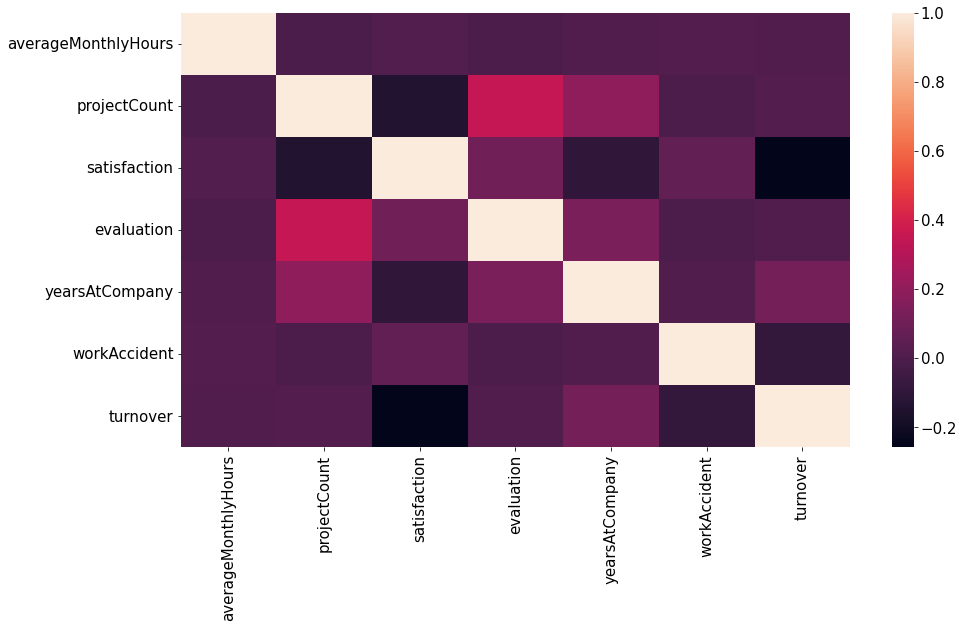

In [20]:
# Tamanho da plotagem.
plt.rcParams["figure.figsize"] = (15, 8)

# Tamanho das fontes.
plt.rcParams["axes.titlesize"] = 20  # Título.
plt.rcParams["xtick.labelsize"] = 15  # Valores em x.
plt.rcParams["ytick.labelsize"] = 15  # Valores em y.
plt.rcParams["axes.labelsize"] = 20  # Rótulos dos eixos.

# Matriz de correlação.
corr = df.corr()

# Mapa de calor da matriz de correlação.
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

plt.show()

In [21]:
corr

,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
averageMonthlyHours,1.000000,-0.009790,0.007669,-0.007087,0.004822,0.011991,0.002815
projectCount,-0.009790,1.000000,-0.142970,0.349333,0.196786,-0.004741,0.014262
satisfaction,0.007669,-0.142970,1.000000,0.105021,-0.100866,0.058697,-0.259428
evaluation,-0.007087,0.349333,0.105021,1.000000,0.131591,-0.007104,0.002625
yearsAtCompany,0.004822,0.196786,-0.100866,0.131591,1.000000,0.002120,0.118877
workAccident,0.011991,-0.004741,0.058697,-0.007104,0.002120,1.000000,-0.091420
turnover,0.002815,0.014262,-0.259428,0.002625,0.118877,-0.091420,1.000000


**Atributos com uma correlação moderada positiva:** 
* projectCount vs evaluation  : ~ 0.35
* projectCount vs yearsCompany: ~ 0.20

**Atributos com uma correlação moderada negativa:**
* satisfaction vs turnover: ~ -0.26

**Questões:**
* Quais atributos afetam nossa variável alvo (turnover)?
* Existem atributos com alta correlação entre eles?
* Como podemos aprofundar para entender as correlações?

**Resumo:**

* Existe uma **correlação positiva** entre os atributos projectCount e evaluation;
* Faz sentido que empregados que estão envolvidos em mais projetos, trabalham mais e tem melhor avaliação;
* Existe uma **correlação negativa** entre os atributos satisfaction e turnover;
* Podemos assumir que empregados que mais deixam a empresa estão menos satisfeitos.

#### Visualizando as distribuições dos atributos.

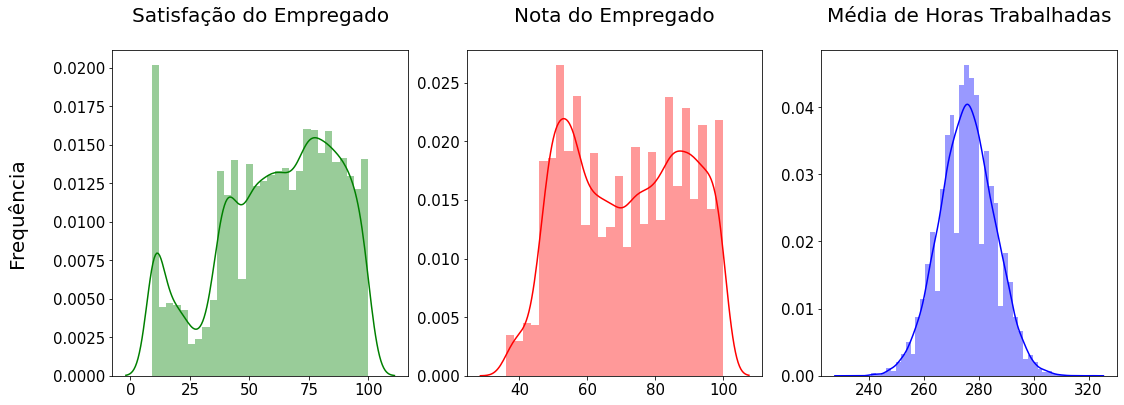

In [22]:
# Grade de plotagem com 3 colunas.
f, axes = plt.subplots(ncols=3, figsize=(18, 6))

# Iterando 3 distribuições: Satisfação, Horas Médias Mensais e Nota.
for column, color, title, index in zip(
    ("satisfaction", "evaluation", "averageMonthlyHours"),
    ("g", "r", "b"),
    ("Satisfação do Empregado", "Nota do Empregado", "Média de Horas Trabalhadas"),
    range(3),
):

    sns.distplot(df[column], color=color, ax=axes[index]).set_title(
        "{}\n".format(title)
    )
    axes[index].set_ylabel("")
    axes[index].set_xlabel("")

axes[0].set_ylabel("Frequência\n")
plt.show()

**Resumo**

**Satisfaction:**
* Existe um pico de empregados com baixa satisfação, mas a maior concentração está entre 60 e 80;

**Evaluation:**
* Temos uma distribuição bimodal de empregados com avaliações baixas para notas menores que 60, e altas para maiores que 80;

**AverageMonthlyHours:**
* A concentração da quantidade de horas trabalhadas nos últimos 3 meses está ao redor da média em 275 horas.

**Questões:** 
 - Existe uma razão para o pico de empregados insatisfeitos?

#### Verificando o turnover em relação ao salário.

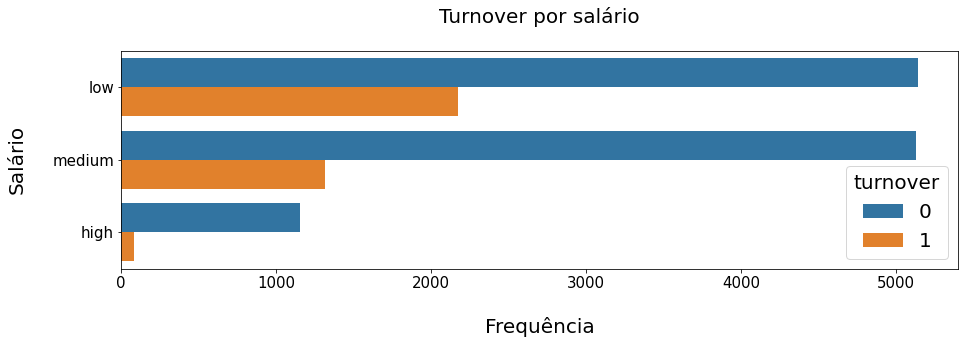

In [23]:
f, ax = plt.subplots(figsize=(15, 4))

# Tamanho da fonte da legenda.
plt.rcParams["font.size"] = 20

sns.countplot(y="salary", hue="turnover", data=df).set_title("Turnover por salário\n")
plt.ylabel("Salário\n")
plt.xlabel("\nFrequência")

plt.show()

**Resumo**
 - A maioria dos empregados que saíram tinha salário **baixo** ou **médio**;
 - Quase nenhum empregado com alto salário deixou a empresa.
 
**Questões:** 
 - Como é o ambiente de trabalho? Isso se difere por salário?
 - O que faz empregados com alto salário sairem da empresa.

#### Verificando o turnover em relação departamento.

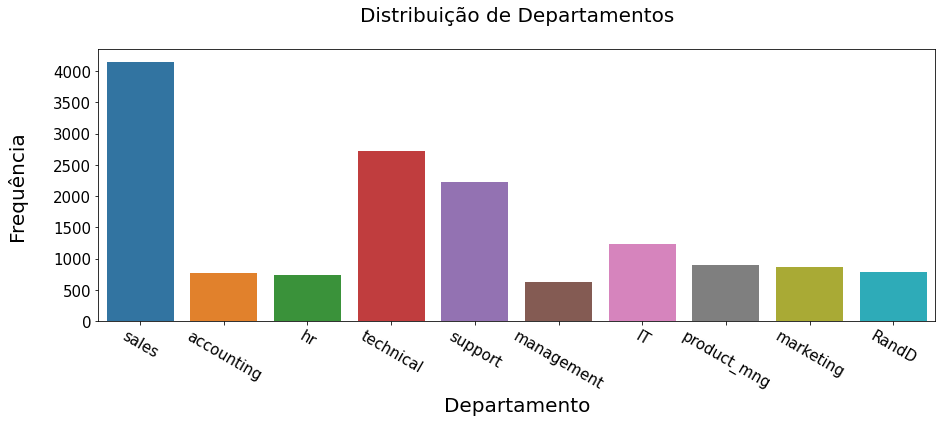

In [24]:
f, ax = plt.subplots(figsize=(15, 5))

plt.rcParams["xtick.labelsize"] = 15

# Rotação de -30° (horário) nos rótulos no eixo x.
plt.xticks(rotation=-30)

sns.countplot(x="department", data=df).set_title("Distribuição de Departamentos\n")
plt.ylabel("Frequência\n")
plt.xlabel("Departamento")

plt.show()

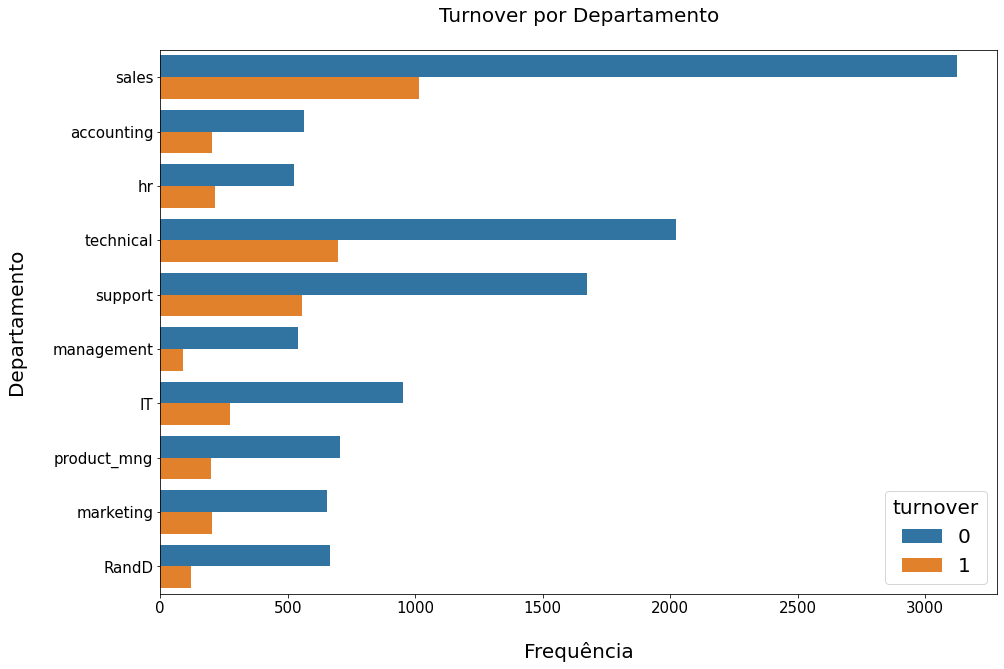

In [25]:
f, ax = plt.subplots(figsize=(15, 10))

sns.countplot(y="department", hue="turnover", data=df).set_title(
    "Turnover por Departamento\n"
)
plt.ylabel("Departamento\n")
plt.xlabel("\nFrequência")

plt.show()

**Resumo:**
* Os departamentos de vendas, técnico e suporte são o top 3 departamentos com maior índice de turnover;
* O departamento management tem o menor volume de turnover.

**Questões:** 
* Será que examinar em profundidade os departamentos que tem maior índice de turnover e o menor pode nos revelar mais informações importantes?
* Qual o salário nestes departamentos?

#### Verificando o turnover em relação ao número de projetos.

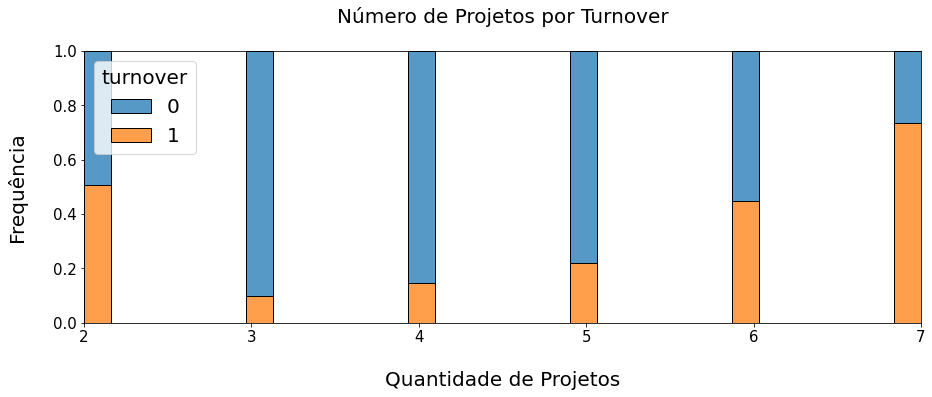

In [26]:
fig = plt.figure(figsize=(15, 5))

sns.histplot(x="projectCount", hue="turnover", data=df, stat="percent", multiple="fill")
plt.ylabel("Frequência\n")
plt.xlabel("\nQuantidade de Projetos")
plt.title("Número de Projetos por Turnover\n")

plt.show()

**Resumo:**
* Muitos empregados com **2, 6 e 7 projetos** deixam a empresa;
* A maioria dos empregados que permancem na empresa estão envolvidos de **3 a 5 projetos**;
* Existe uma pequena **tendência de crescimento no índice de turnover** em relação à quantidade de projetos.
 
**Questões:**
* Porque os empregados estão deixando a empresa em relação à quantidade de projetos?
* Será que faz sentido pensar que empregados envolvidos em 2 ou menos projetos estão desmotivados e por isso deixam a empresa?
* Será que empregados envolvidos em mais que 6 projetos se sintam sobrecarregados e deixam a empresa?

#### Verificando o turnover em relação à nota de avaliação.

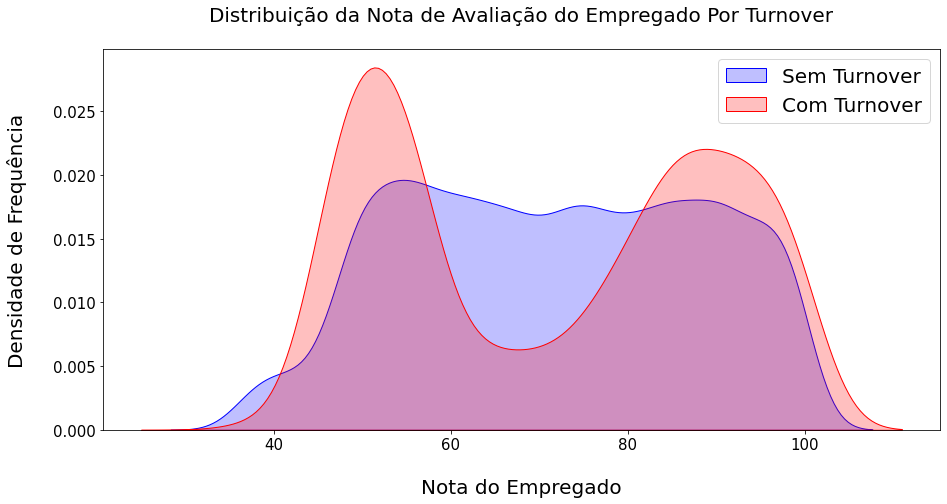

In [27]:
fig = plt.figure(figsize=(15, 7))

sns.kdeplot(
    df.loc[(df["turnover"] == 0), "evaluation"],
    color="b",
    shade=True,
    label="Sem Turnover",
)
sns.kdeplot(
    df.loc[(df["turnover"] == 1), "evaluation"],
    color="r",
    shade=True,
    label="Com Turnover",
)
plt.ylabel("Densidade de Frequência\n")
plt.xlabel("\nNota do Empregado")
plt.title("Distribuição da Nota de Avaliação do Empregado Por Turnover\n")

plt.legend()
plt.show()

**Resumo:** 
* Temos uma distribuição bimodal para o conjunto que deixou a empresa;
* Colaboradores com **baixa performance** tendem a deixar a empresa;
* Colaboradores com **alta performance** tendem a deixar a empresa;
* O **ponto ideal** para os funcionários que permaneceram está dentro da avaliação de 60 a 80.

#### Verificando o turnover em relação à satisfação do empregado.

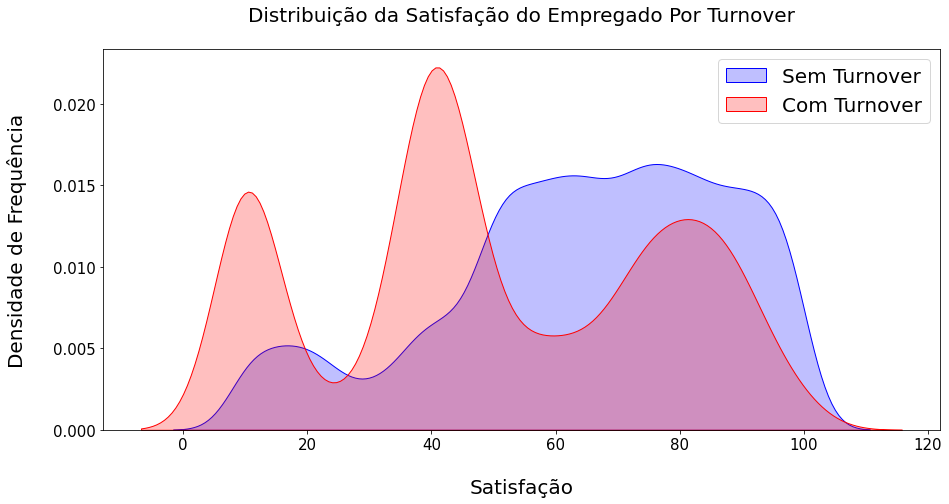

In [28]:
fig = plt.figure(figsize=(15, 7))

sns.kdeplot(
    df.loc[(df["turnover"] == 0), "satisfaction"],
    color="b",
    shade=True,
    label="Sem Turnover",
)
sns.kdeplot(
    df.loc[(df["turnover"] == 1), "satisfaction"],
    color="r",
    shade=True,
    label="Com Turnover",
)
plt.ylabel("Densidade de Frequência\n")
plt.xlabel("\nSatisfação")
plt.title("Distribuição da Satisfação do Empregado Por Turnover\n")

plt.legend()
plt.show()

**Resumo:** 
* Empregados com o nível de satisfação menor que 20 tendem a deixar a empresa;
* Empregados com o nível de satisfação entre 30 e 50 têm maior probabilidade de deixar a empresa;
* Empregados com uma satisfação entre 50 e 100 são os que menos deixam a empresa.

#### Verificando a relação entre número de projetos e a nota de avaliação do empregado.

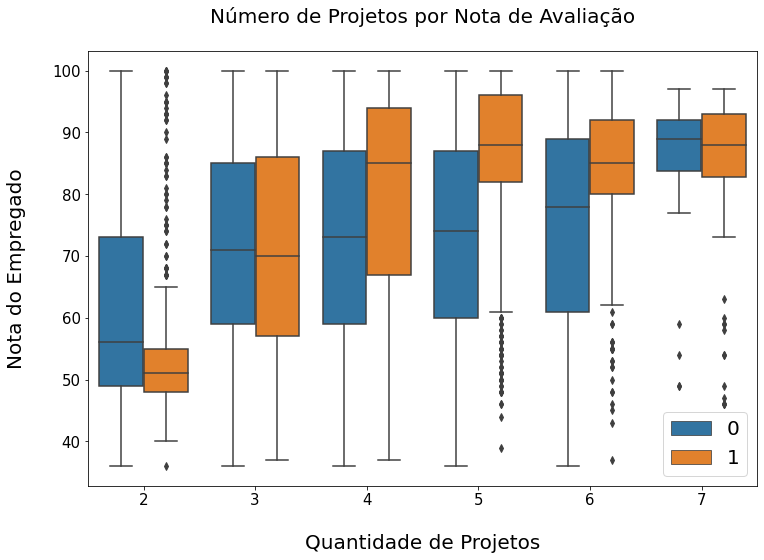

In [29]:
fig = plt.figure(figsize=(12, 8))

sns.boxplot(x="projectCount", y="evaluation", hue="turnover", data=df)
plt.ylabel("Nota do Empregado\n")
plt.xlabel("\nQuantidade de Projetos")
plt.title("Número de Projetos por Nota de Avaliação\n")

plt.legend()
plt.show()

**Resumo:** 
* Há um **aumento na avaliação** para os funcionários que realizaram mais projetos dentro do grupo de quem deixou a empresa;
* Para o grupo de pessoas que permaneceram na empresa, os empregados tiveram uma **pontuação de avaliação consistente**, apesar do aumento nas contagens de projetos;
* Empregados que permaneceram na empresa tiveram uma **avaliação média em torno de 70%**, mesmo com o número de projetos crescendo;
* Esta relação muda drasticamente entre os empregados que deixaram a empresa. A partir de 3 projetos, as **médias de avaliação aumentam consideravelmente**;
* Empregados que tinham **dois projetos e uma péssima avaliação** saíram;
* Empregados com **mais de 3 projetos e avaliações altas** deixaram a empresa.

**Questões:**
* Por que será que os funcionários que saíram tiveram em média uma avaliação superior aos funcionários que não saíram, mesmo com um aumento no número de projetos?
* Os funcionários com avaliações mais baixas não deveriam ter tendência a sair mais da empresa?

#### Verificando a relação entre a satisfação do empregado e a sua avaliação.

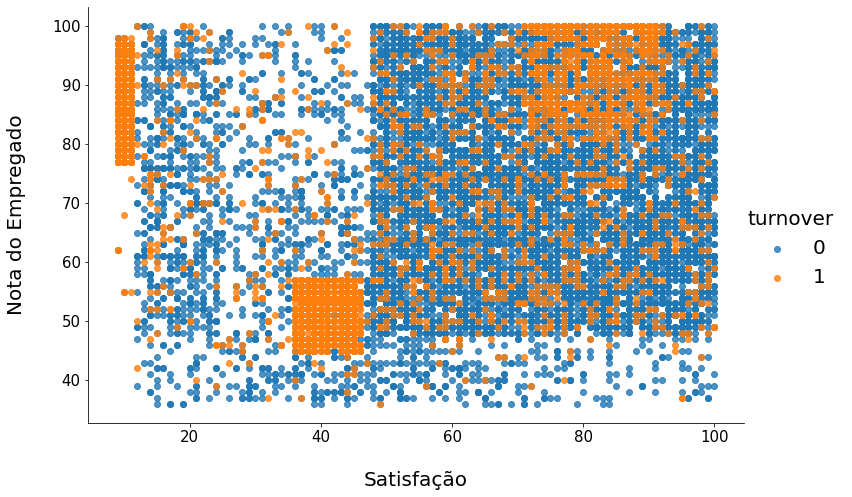

In [30]:
sns.lmplot(
    x="satisfaction",
    y="evaluation",
    data=df,
    fit_reg=False,
    hue="turnover",
    height=7,
    aspect=1.5,
)
plt.ylabel("Nota do Empregado\n")
plt.xlabel("\nSatisfação")

plt.show()

**Resumo:**: Temos aqui 3 grupos distintos de empregados.
 
**Cluster 1 (Empregados insatisfeitos e trabalhadores):** A satisfação foi inferior a 20 e as avaliações foram superiores a 75. 
* O que pode ser uma boa indicação de que os funcionários que deixaram a empresa eram bons trabalhadores, mas se sentiam péssimos no trabalho.

Questões: 
* Qual poderia ser o motivo de se sentir tão mal quando você é altamente avaliado? 
* Será que está trabalhando muito? 
* Esse cluster poderia significar funcionários que estão "sobrecarregados"? 
 
**Cluster 2 (Empregados ruins e insatisfeitos):** Satisfação entre 35 a 50 e as suas avaliações abaixo de ~ 58. 

Questões:
* Isso pode ser visto como funcionários que foram mal avaliados e se sentiram mal no trabalho;
* Podemos chamar esse grupo de baixo desempenho?

**Cluster 3 (Empregados satisfeitos e trabalhadores):** Satisfação entre 75 a 90 e avaliações superiores a 80. 
* O que poderia significar que os funcionários neste grupo eram "ideais";
* Eles amavam seu trabalho e eram altamente avaliados por seu desempenho.

Questões: 
* Este grupo pode representar os empregados que deixaram a empresa porque encontraram outra oportunidade de trabalho?

### Computando os clusters

In [31]:
# Importando o algoritmo não-supervisionado KMeans para clusterizar os dados.
from sklearn.cluster import KMeans

#### Inicializando os clusters.

In [32]:
# Procuraremos por 3 clusters. Para permitir reproducibilidade usaremos uma semente fixa (2).
kmeans = KMeans(n_clusters=3, random_state=2)

#### Definindo o conjunto de dados.

In [33]:
df_turnover = df[df.turnover == 1][["satisfaction", "evaluation"]]

#### Clusterizando.

In [34]:
kmeans.fit(df_turnover)

KMeans(n_clusters=3, random_state=2)

In [35]:
# Definindo uma lista de cores.
kmeans_colors = [
    "green" if c == 0 else "red" if c == 1 else "blue" for c in kmeans.labels_
]

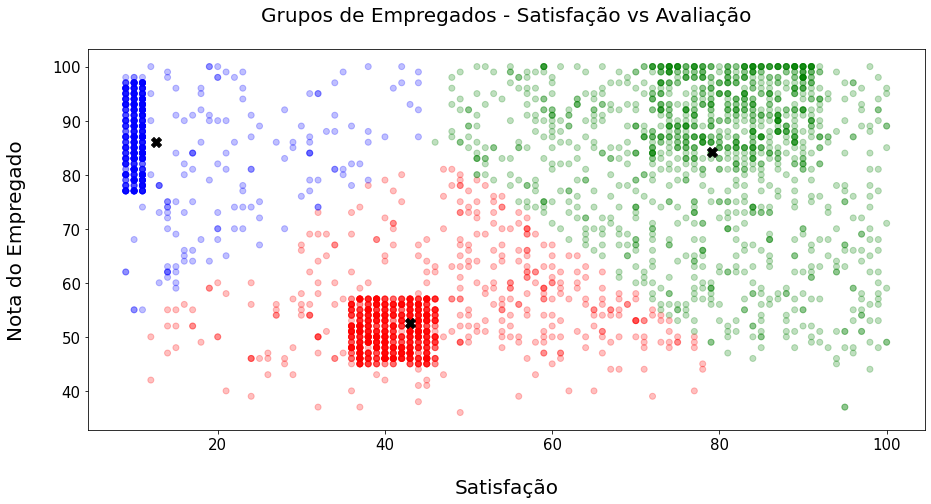

In [36]:
fig = plt.figure(figsize=(15, 7))

# Plotagem de todos os funcionários que tiveram turnover.
plt.scatter(
    x="satisfaction", y="evaluation", data=df_turnover, alpha=0.25, color=kmeans_colors
)

# Plotagem dos centróides de cada cluster.
plt.scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    color="k",
    marker="X",
    s=100,
)
plt.title("Grupos de Empregados - Satisfação vs Avaliação\n")
plt.ylabel("Nota do Empregado\n")
plt.xlabel("\nSatisfação")

plt.show()

#### Verificando a relação entre o tempo de empresa e o turnover.

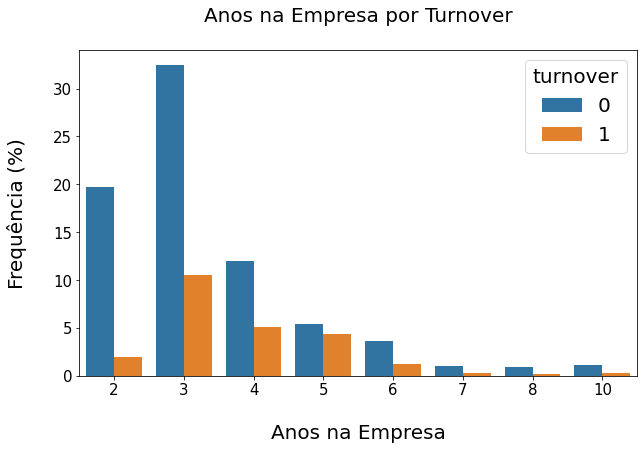

In [37]:
fig = plt.figure(figsize=(10, 6))

sns.barplot(
    x="yearsAtCompany",
    y="yearsAtCompany",
    hue="turnover",
    data=df,
    estimator=lambda x: len(x)
    / len(df)
    * 100,  # Função anônima estimadora da porcentagem.
)
plt.title("Anos na Empresa por Turnover\n")
plt.ylabel("Frequência (%)\n")
plt.xlabel("\nAnos na Empresa")

plt.show()

**Resumo:**
* Empregados com **4 e 5 anos de casa** deixaram a empresa;
* Empregados acima de **5 anos de casa** devem ser examinados.
 
**Questões:**
* Por que os empregados estão saindo principalmente na faixa de 3-5 anos?
* Quem são esses empregados que saíram?

#### Persistindo o objeto cluster para o disco.

In [38]:
import joblib

# Salvando o modelo de clusters kmeans como cluster.joblib no diretório atual.
joblib.dump(kmeans, "cluster.joblib")

['cluster.joblib']

#### Transferindo o arquivo para o datalake.

In [39]:
client.fput_object(
    "curated",  # Nome do bucket.
    "cluster.joblib",  # Nome do arquivo no diretório atual.
    "cluster.joblib",  # Nome que o arquivo vai receber dentro do bucket.
)

### Sweetviz

In [40]:
import sweetviz as sv

In [41]:
relatorio = sv.analyze(df, "turnover")
relatorio.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Limpando o diretório atual.

In [42]:
import os

In [43]:
for file in ("temp_.parquet", "cluster.joblib"):
    os.remove(os.getcwd() + f"\\{file}")